In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import numpy as np
import cv2
from dataset import SamDataset
import torch
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
dataroot = '/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD' #Change this to match the computer you are working from!
data_path=Path(dataroot, 'annotations.json')
if not data_path.is_file():
    raise(FileNotFoundError(f"File '{data_path}' doesn't exist."))

In [4]:
str(data_path)

'/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD/annotations.json'

In [8]:
%%time
train_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='train')
val_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

CPU times: user 1.01 s, sys: 104 ms, total: 1.11 s
Wall time: 1.14 s


Let's try to get the segments from the dataloader output

Utility functions for plotting SAM output

In [78]:
# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)
    
# def show_points(coords, labels, ax, marker_size=375):
#     pos_points = coords[labels==1]
#     neg_points = coords[labels==0]
#     ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
#     ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# # bbox_transform = lambda x: torch.tensor([x[0],x[1],x[0]+x[2],x[1]+x[3]]) # utility function for transforming box coordinates in (x,y,w,h) to (x1,y1,x2,y2)

In [9]:
!nvidia-smi

Wed Mar 13 14:13:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A16                     On  | 00000000:CF:00.0 Off |                    0 |
|  0%   36C    P0              25W /  62W |     87MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
# %%time
for data, label in val_loader:
    # print(data[0]['image_path'])
    image_path = data['image_path']
    masks = data['masks']
    bbox = data['bbox']

    image = cv2.imread(image_path[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, val_dataset.imres)
    print(f'{bbox=}')

    print(label)
    break

IndexError: too many indices for tensor of dimension 4

data.shape=torch.Size([32, 256, 256, 3])
permutted_data.shape=torch.Size([32, 3, 256, 256])


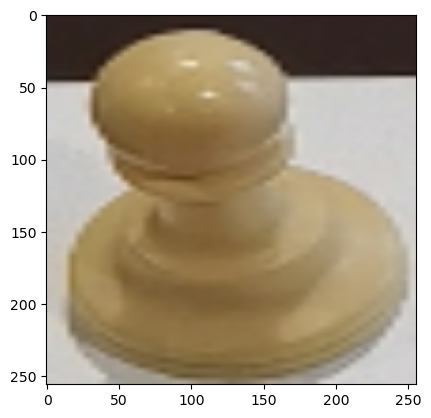

In [53]:
print(f'{data.shape=}')
permutted_data = data.permute(0,3,1,2)
print(f'{permutted_data.shape=}')
plt.imshow(permutted_data.permute(0,2,3,1)[0])

In [87]:
!nvidia-smi

Wed Mar 13 15:04:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A16                     On  | 00000000:CF:00.0 Off |                    0 |
|  0%   36C    P0              25W /  62W |    107MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Show segmentation result

tensor([529, 277, 574, 363], device='cuda:0', dtype=torch.int32)


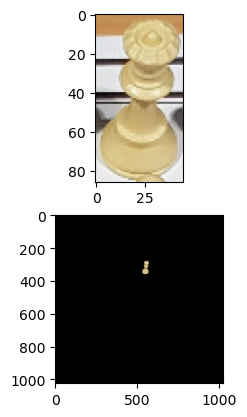

In [63]:
# plt.imshow(image * masks[0][0,0,...,np.newaxis].cpu().numpy())
# bbox[0]
# image_path[0]
# image = np.load(image_path[0])
image = cv2.imread(image_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, val_dataset.imres)
x = bbox[0].int()
print(x)
fig, ax = plt.subplots(2)
ax[0].imshow(image[x[1]:x[3],x[0]:x[2]])
ax[1].imshow(image * masks[0][0,0,...,np.newaxis].cpu().numpy())

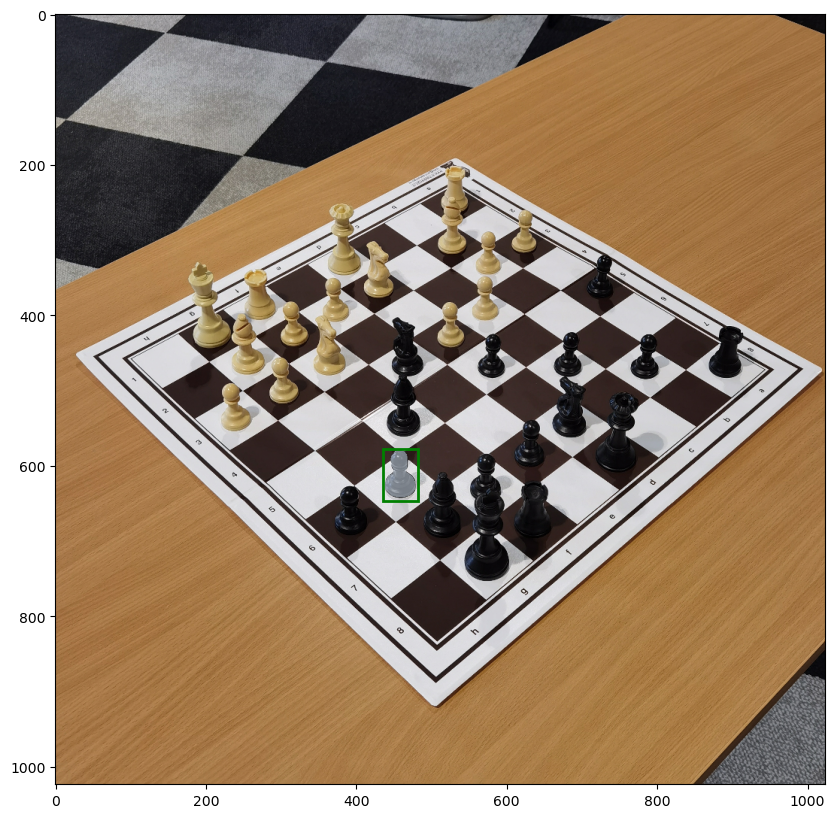

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in bbox:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()

In [61]:
from bw_model import PieceClassifier

In [101]:
model = PieceClassifier()
model.to(device)

PieceClassifier(
  (model): Sequential(
    (0): Conv2d(3, 4, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (3): ReLU(inplace=True)
    (4): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=8, stride=8, padding=1, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=64, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [99]:
print(f'{permutted_data.shape=}')
# print(permutted_data.reshape(permutted_data.shape).shape)
test = model.forward(permutted_data.float())
permutted_data[0,0,0,0].dtype
torch.moveaxis(data, -1, 1).float().shape

permutted_data.shape=torch.Size([32, 3, 256, 256])
Feature_maps.shape=torch.Size([32, 16, 2, 2])


torch.Size([32, 3, 256, 256])

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.nn.CrossEntropyLoss()
    

In [110]:
import tqdm
from livelossplot import PlotLosses
import torchvision

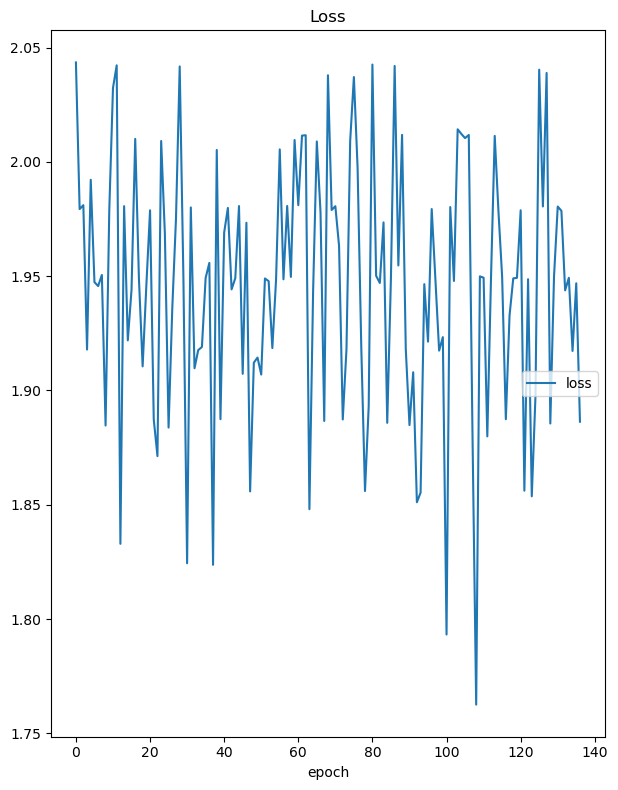

137it [10:20,  3.34s/it]

Loss
	loss             	 (min:    1.763, max:    2.043, cur:    1.886)


137it [10:22,  4.54s/it]


KeyboardInterrupt: 

In [112]:
liveloss = PlotLosses()
device = 'cuda'
epochs = 2
for epoch in range(epochs):
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        crops, labels = batch

        crops = crops.to(device=device)
        labels = labels.to(device=device).long()
        crops = torch.moveaxis(crops, -1, 1).float() # Matching the order of the axes from the DataLoader to the model's expectations.
        IMAGENET_MEAN = [0.485, 0.456, 0.406] 
        IMAGENET_STD = [0.229, 0.224, 0.225]
        
        # Normalize the images using the mean and std values of the ImageNet dataset.
        normalize = torchvision.transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        crops = normalize(crops)
        # >> Zero the gradients of the optimizer
        optimizer.zero_grad()

        # >> Run the model on the imgs
        preds = model(crops)

        # >> Calculate the loss
        l = loss(preds, labels)

        # >> Propogate back the gradients from the loss to the input
        l.backward()

        # >> Apply one step of optimization the oprimixation function.        
        optimizer.step()
        
        liveloss.update({"loss": l.item()})
        liveloss.draw()